# A linear separation

This post deals with the very basic problem of linear separability, using some of the simplest tools available in the Python ecosystem. We'll look at how to decide if two classes can be discriminated by a linear classifier, and how to find a separating linear boundary.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from utils import *

We need a dataset with linearly separable classes. The _Iris_ [dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) has three classes, but we'll declare _setosa_ to be class $1$, and lump _versicolor_ and _virginica_ into class $-1$.

In [50]:
from sklearn.datasets import load_iris, make_classification
iris = load_iris()
X = iris.data
t = iris.target
idx_setosa = (t == 0)
t[ idx_setosa] =  1
t[~idx_setosa] = -1

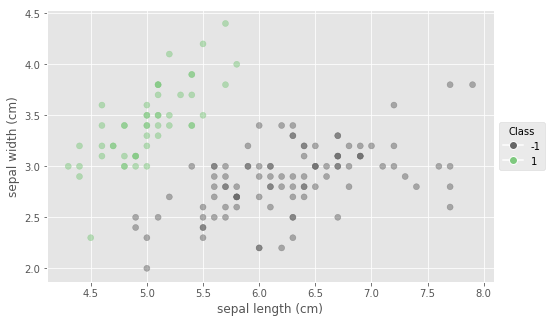

In [51]:
fig, ax = plot_scatter(X, t, [0, 1],
                       xlabel=iris.feature_names[0],
                       ylabel=iris.feature_names[1])
add_legend(ax, t)

The separation looks quite narrow. Lets see how quickly we can find a separating boundary, if at all.

# The perceptron learning algorithm

The PLA visits each exemplar in sequence and adjusts the normal vector each time it finds that the current data point is on the wrong side of the boundary. The adjustment is such that the boundary is now more likely to have the current data point on the correct side, but this also might make the situation worse for other data points. Fortunately, one can show that if the dataset is linearly separable, the perceptron learning algorithm will converge (see e.g. Andrew Ng's [handouts](http://cs229.stanford.edu/materials.html) for CS229). However, the upper bound on the number of updates is proportional to the reciprocal of the square of the separation between the two classes. Since our two classes look barely separable, this means we might have to wait a long time for the perceptron to hit upon a separating hyperplane.

In [52]:
def PLA(X, niter=1000):
    X = np.c_[np.ones(len(X)), X]     # augment the dataset
    w = np.random.rand(X.shape[1])    # random initialisation
    num_errors = np.zeros(niter) - 1  # error array for plotting
    a, b = 10, 1000
    weights = []
    for i in range(niter):
        eta = a/(b + i)               # hyperbolic schedule for the learning rate
        n_err = 0
        for n in range(len(X)):       # take each data point in turn
            xn, tn = X[n, :], t[n]
            if w @ xn * tn <= 0:      # xn is missclassified
                n_err += 1            # increase the error count
                w += eta * xn * tn    # and adjust the hyperplane
                weights.append(w.copy())
        num_errors[i] = n_err
        if n_err == 0: # no missclassifications in the entire dataset
            print(f"Linearly separability determined in {i} iterations")
            return w, num_errors[:i+1], weights
    print(f"Linearly separability could not be determined in {niter} iterations")
    return w, num_errors, weights

def plot_errors(err_array):
    from matplotlib.ticker import MaxNLocator
    locator = MaxNLocator(integer=True)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(num_errors, 'r', marker='$\circ$', 
            linestyle='-', linewidth=0.3, alpha=0.6)
    ax.yaxis.set_major_locator(locator)
    ax.grid(True, which='major', axis='y')
    ax.set(title='Number of errors vs. number of iterations',
           ylabel='Number of errors',
           xlabel='Iterations')
    plt.show()

Linearly separability determined in 483 iterations


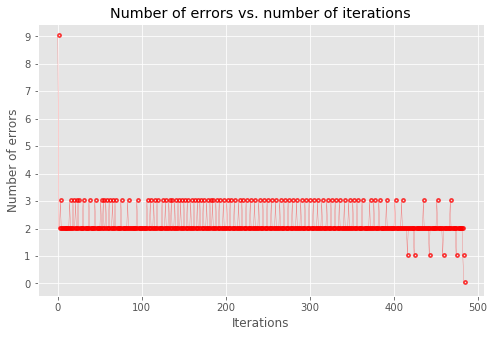

In [54]:
w_perceptron, num_errors, weights = PLA(X[:, :2], niter=1000)
plot_errors(num_errors)

Let's plot the last couple of positions of the boundary. The boundary jumps around quite a lot - it's now clearer why we had to reduce the learning rate. We could try to ajust it even more; as a rule hyperbolic and exponential schedules both usually work fine.

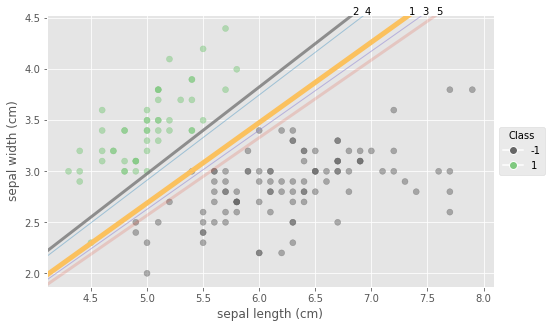

In [55]:
def plot_last_positions():
    fig, ax = plot_scatter(X, t, [0, 1],
                       xlabel=iris.feature_names[0],
                       ylabel=iris.feature_names[1])
    add_legend(ax, t)
    for i in reversed(range(1, 6)):
        plot_boundary(ax, weights[-i], ann=str(i),
                      linewidth=7-2*i, alpha=1-2*(i-1)/10)
    plt.show()
plot_last_positions()

That takes on average around 500 iterations. Had we used a constant learning rate, it would have taken a couple hundred more.

Let's increase the separation artificially by nudging the sepal width of the bottom left _setosa_ exemplar up half a centimetre.

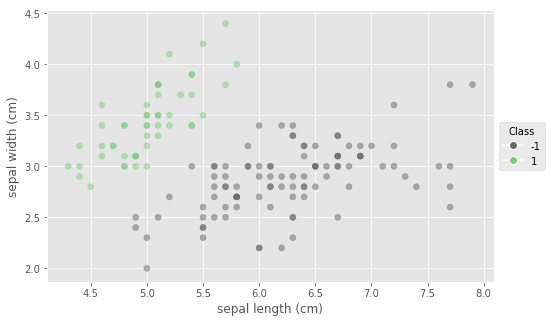

In [56]:
X[(X[:, 0] < 4.6) & (X[:, 1] < 2.5)] += np.array([[0, 0.5, 0, 0]])
fig, ax = plot_scatter(X, t, [0, 1], cls=1, 
                       xlabel=iris.feature_names[0],
                       ylabel=iris.feature_names[1])
add_legend(ax, t)

That looks much better. Let's see how this affects the number of iterations. Before actually running the computation, let's compute the upper bound on the number of iterations, provided by the convergence proof: $\dfrac{D}{\gamma^2}$, where $D$ is the largest vector norm in the training set, and gamma is the separation between the two classes. We'll eyeball the separation between the two classes for now at $\gamma=0.25$, and see how we can compute it exactly later.

While we're computing the lengths of all the vectors in the training set, in order to find the largest, let's plot the entire distribution, just to see if larger lengths are associated with one of the classes.

In [57]:
def plot_length_dist(X):
    # get the array of lengths
    lengths = np.sqrt(np.sum(X**2, axis=1))
    fig, ax = plt.subplots()
    ax.hist(lengths[t== 1], color='red',alpha=0.3, normed=True, label='setosa')
    ax.hist(lengths[t==-1], color='blue', alpha=0.3, normed=True, 
            label='vers. & virg.')
    kde_kws = dict(color="k", label="KDE all")
    sns.distplot(lengths, ax=ax, bins=20, rug=True, **kde_kws)
    ax.legend()
    plt.show()

The histogram and kernel density plot do indeed show a bimodal distribution.

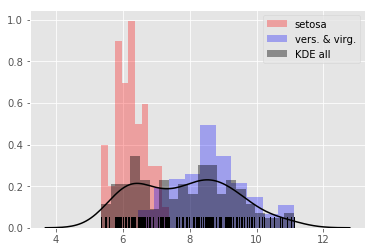

In [58]:
plot_length_dist(X)

The largest length is just over 11 cm, so the upper bound on the number of iterations turns out to be:

In [59]:
np.ceil(11/0.25**2)

176.0

The perceptron manages now to find a separating boundary in few tens of iterations; the upper bound we computed is not exactly tight.

Linearly separability determined in 16 iterations


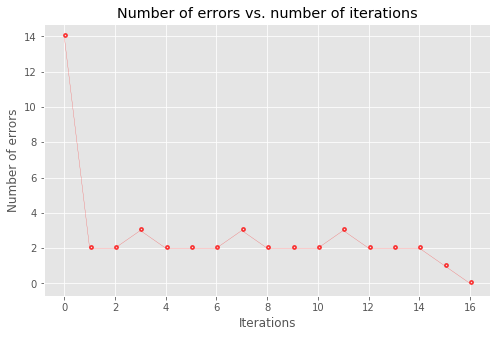

In [65]:
w_perceptron, num_errors, _ = PLA(X[:, :2], niter=1000)
plot_errors(num_errors)

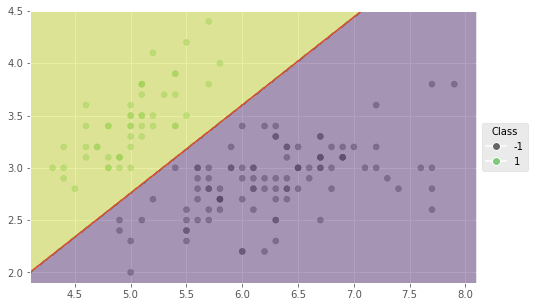

In [66]:
fig, ax = plot_scatter(X, t, cols=[0, 1])
plot_classification(ax, w_perceptron, mesh_size=0.01)
plot_boundary(ax, w_perceptron)
add_legend(ax, [-1, 1])

# Linear separability. Linear program

If the dataset is linearly separable, a [linear program](https://en.wikipedia.org/wiki/Linear_programming) will be able to find a solution to the system of inequalities $$t_n \mathbf{w}^T \mathbf{x}_n \geq 0, \forall n \in \{1 \dots N\}.$$

We'll use the `cvxopt` python package, to find a solution to our system of inequalities.

In [67]:
import cvxopt as cvx

The `cvxopt.solvers.lp` function solves the pair of primal and dual linear programs:

![cvxopt linear program](http://cvxopt.org/userguide/_images/math/1a46f87937c463caee0344c11e4563de96c4cb12.png)

Since we're just interested in satisfying the constraints, we can choose the simplest objective possible, i.e. the constant $0$.

\begin{equation*}
\begin{aligned}
    \text{minimise} \quad  & \mathbf{0}^T \mathbf{w}\\
    \text{subject to} \quad & t \odot X \mathbf{w} \geq \mathbf{0}
\end{aligned}
\end{equation*}

Our system of inequalities will be satisfied if the solver can find a solution to `Gx + s = h`, for some positive vector `s`. This allows us to specify any reasonable positive vector for `h`. The $n$-vector of all ones looks like a reasonable choice. Let's try it.

In [69]:
def lp(X, t):
    X = np.c_[np.ones_like(t), X]
    t = t.reshape(-1, 1) # to make it compatible with X for component-wise *
    G = cvx.matrix(t * X, tc='d')
    h = cvx.matrix(np.ones_like(t), tc='d')
    c = cvx.matrix(np.zeros((X.shape[1], 1)), tc='d')
    res = cvx.solvers.lp(c, G, h) # solve the linear program
    return np.array(res['x']) # return the normal to the separating hyperplane

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.5000e+02  4e+02  2e+00  4e+02  1e+00
 1:  0.0000e+00 -1.5885e+01  1e+01  3e-01  5e+01  2e+00
 2:  0.0000e+00 -2.0380e-01  2e-01  4e-03  7e-01  5e-02
 3:  0.0000e+00 -2.0343e-03  2e-03  4e-05  7e-03  5e-04
 4:  0.0000e+00 -2.0343e-05  2e-05  4e-07  7e-05  5e-06
 5:  0.0000e+00 -2.0343e-07  2e-07  4e-09  7e-07  5e-08
 6:  0.0000e+00 -2.0343e-09  2e-09  4e-11  7e-09  5e-10
Optimal solution found.


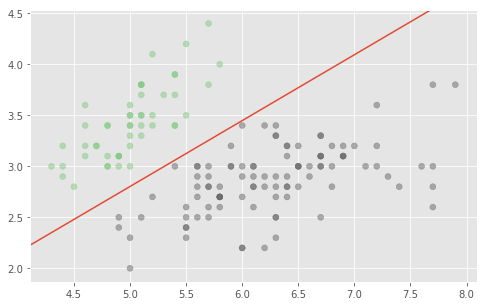

In [70]:
fig, ax = plot_scatter(X, t, [0, 1])
w_lp = lp(X[:, :2], t)
plot_boundary(ax, w_lp.ravel())

# Linearly separability. Quadratic program

Of course, we could check the feasibility of the constraints doing even more work. Let's solve a quadratic program, again with a bogus constant objective:

![](http://cvxopt.org/userguide/_images/math/4a1d5a88630fc2310b16135d0ae191d396ebae9e.png)

\begin{equation*}
\begin{aligned}
    \text{minimise} \quad  & \mathbf{w}^T \mathbf{O} \mathbf{w} +  \mathbf{q}^T \mathbf{0}\\
    \text{subject to} \quad & -t \odot X \mathbf{w} \leq \mathbf{0}
\end{aligned}
\end{equation*}

Notice that the same constraints have to written now in a slightly different form to conform to the API of `cvxopt.solvers.qp`.

In [71]:
def qp(X, t):
    X = np.c_[np.ones_like(t), X]
    t = t.reshape(-1, 1)
    G = cvx.matrix(-t * X, tc='d')
    h = cvx.matrix(np.zeros_like(t), tc='d')
    P = cvx.matrix(np.zeros((X.shape[1], X.shape[1])), tc='d')
    q = cvx.matrix(np.zeros(X.shape[1]).reshape(-1, 1), tc='d')
    res = cvx.solvers.qp(P, q, G, h)
    return np.array(res['x'])

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  2e+02  1e+01  4e+02
 1:  0.0000e+00 -2.8243e+01  4e+01  3e+00  9e+01
 2:  0.0000e+00 -1.6468e+00  2e+00  1e-01  4e+00
 3:  0.0000e+00 -1.7053e-02  2e-02  1e-03  4e-02
 4:  0.0000e+00 -1.7055e-04  2e-04  1e-05  4e-04
 5:  0.0000e+00 -1.7055e-06  2e-06  1e-07  4e-06
 6:  0.0000e+00 -1.7055e-08  2e-08  1e-09  4e-08
Optimal solution found.


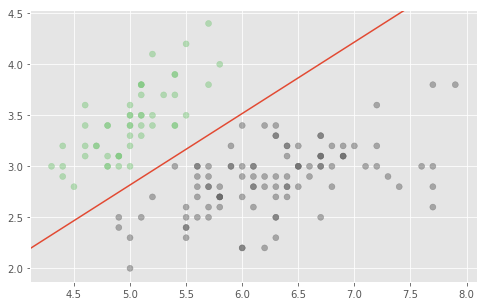

In [72]:
fig, ax = plot_scatter(X, t, [0, 1])
w_qp = qp(X[:, :2], t)
plot_boundary(ax, w_qp.ravel())

The solution is different from the one found by the linear solver. In fact we may wonder, which one we should prefer? Well, since we have all this power at our hands, we could use it to solve a non-trivial objective. Maybe we can find a way to express some quality of the decision boundary as a quadratic objective. If we could do that, we would be home free. 

For example, how about finding the separating hyperplane that maximises the minimum distance from it to the closest vectors in the training set. This would likely help us make less errors when classifying previously unseen data points.

We'll look at the matter in the next post.